# Курс аналитик данных на Python
## Модуль 6.4 Практика

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### wine reviews<br>
country - The country that the wine is from <br>
designation - The vineyard within the winery where the grapes that made the wine are from<br>
points - The number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for wines that score >=80)<br>
price - The cost for a bottle of the wine<br>
province - The province or state that the wine is from<br>
region_1 - The wine growing area in a province or state (ie Napa)<br>
region_2 - Sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank<br>
taster_name<br>
taster_twitter_handle<br>
title - The title of the wine review, which often contains the vintage if you're interested in extracting that 
feature<br>
variety - The type of grapes used to make the wine (ie Pinot Noir)<br>
winery - The winery that made the wine<br>

In [7]:
df = pd.read_csv('../data/winemag-data_first150k.csv')

In [8]:
df = df.dropna()  # уберём все n/a

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39241 entries, 0 to 150916
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   39241 non-null  int64  
 1   country      39241 non-null  object 
 2   description  39241 non-null  object 
 3   designation  39241 non-null  object 
 4   points       39241 non-null  int64  
 5   price        39241 non-null  float64
 6   province     39241 non-null  object 
 7   region_1     39241 non-null  object 
 8   region_2     39241 non-null  object 
 9   variety      39241 non-null  object 
 10  winery       39241 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 3.6+ MB


In [ ]:
df.head()

Базовая идея №1. Нужно поделить цену на два интервала, чтобы разбить на `дешёвые` и `дорогие` вина

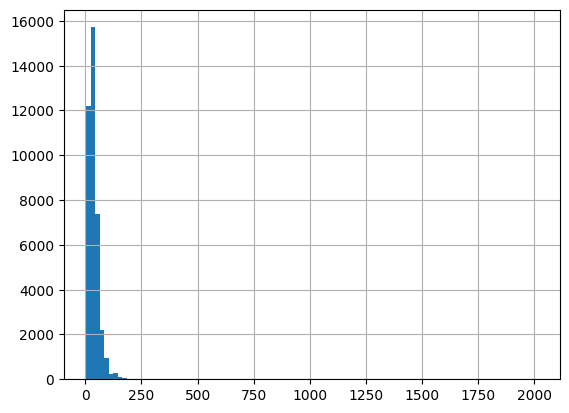

In [11]:
df['price'].hist(bins=100);

Видим `тяжёлый правый хвост`, другими словами есть очень дорогие вина по сравнению со всеми остальными. Такие данные называются `выбросами`. Отфильтруем выбросы:

<Axes: >

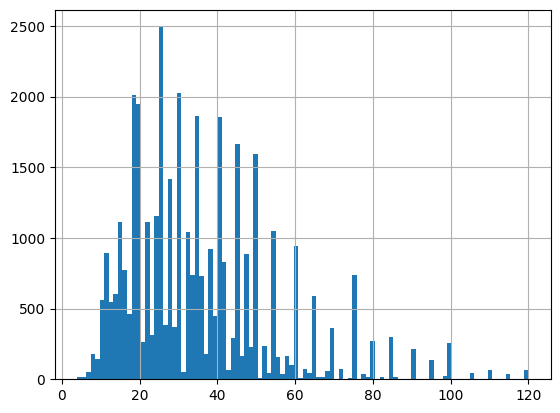

In [12]:
df[df['price'] < df['price'].quantile(0.99)]['price'].hist(bins=100)
#  фильтр через квантиль 99% 

In [13]:
df['price'].mean(), df['price'].median()
# медиана сильно левее среднего. Среднее более чувствительно к выбросам 

(37.54631635279427, 32.0)

Будем использовать для деления `медиану`.

In [14]:
threshold = df['price'].median()
df['is_swag'] = df['price'].apply(lambda x: 1 if x > threshold else 0)

In [15]:
df[df['is_swag'] == 1].shape, df[df['is_swag'] == 0].shape

((19278, 12), (19963, 12))

Получилось примерно одинаковое количество в каждом разделении - это хорошо.

## Доверительные интервалы для доли

На основе той же самой нормальной аппроксимации
$$\hat{p}\pm z_{1-\frac{\alpha}{2}} \sqrt{\frac{\hat{p}\left(1-\hat{p}\right)}{n}}$$

In [16]:
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import norm

In [32]:
for province in df['province'].unique():
    df_prop = df[df['province'] == province]
    prop = sum(df_prop['is_swag']) / len(df_prop)
    print(f'proportion swag wines in {province} is {prop}')

proportion swag wines in California is 0.5257905242147284
proportion swag wines in Oregon is 0.5805070793546263
proportion swag wines in Washington is 0.3753675269519765
proportion swag wines in New York is 0.13245901639344262


In [36]:
for province in df['province'].unique():
    df_prop = df[df['province'] == province]
    prop = sum(df_prop['is_swag']) / len(df_prop)
    prop_int = proportion_confint(
        sum(df_prop['is_swag']),
        len(df_prop),
        alpha=0.05,
        method='normal')
    print(f'interval of proportion swag wines in {province} \n is {prop_int}')

interval of proportion swag wines in California 
 is (0.5199991278163051, 0.5315819206131517)
interval of proportion swag wines in Oregon 
 is (0.5629564872321101, 0.5980576714771425)
interval of proportion swag wines in Washington 
 is (0.36323805046059787, 0.38749700344335514)
interval of proportion swag wines in New York 
 is (0.11544531006168147, 0.1494727227252038)


Вывод: в Орегоне производят больше всех дорогих вин. 

Попробуем посчитать для последнего варианта `вручную`:

In [38]:
z=norm.ppf(1 - 0.05 / 2)
prop-z*np.sqrt((prop*(1-prop))/len(df_prop)),
prop + z*np.sqrt((prop*(1-prop))/len(df_prop))

(0.11544531006168147, 0.1494727227252038)

## Доверительные интервалы для средних

Нормальная аппроксимация
$$\bar{X}_n \pm t_{1-\frac{\alpha}{2}} \frac{S}{\sqrt{n}}$$

In [20]:
from statsmodels.stats.weightstats import _tconfint_generic

In [21]:
swag_mean_points = df[df['is_swag'] == 1]['points'].mean()
swag_mean_std = df[df['is_swag'] == 1]['points'].std()/np.sqrt(len(df[df['is_swag'] == 1]['points']))

cheap_mean_points = df[df['is_swag'] == 0]['points'].mean()
cheap_mean_std = df[df['is_swag'] == 0]['points'].std()/np.sqrt(len(df[df['is_swag'] == 0]['points']))

In [22]:
swag_mean_points, cheap_mean_points

(89.88141923436041, 86.89074788358464)

In [41]:
swag_interval = _tconfint_generic(
    swag_mean_points, swag_mean_std, 
    len(df[df['is_swag'] == 1]['points']) - 1, 0.01,
    alternative='two-sided')
cheap_interval = _tconfint_generic(
    cheap_mean_points, cheap_mean_std, 
    len(df[df['is_swag'] == 0]['points']) - 1, 0.01,
    alternative='two-sided')


In [40]:
print(swag_interval)
print(cheap_interval)

(89.82045903531103, 89.94237943340978)
(86.83783303611764, 86.94366273105163)


Вывод: есть смысл тратить деньги на более дорогие вина, так как они получают более высокую оценку

## Bootstrap

<center><img src="../img/bootstrap.png" alt="lokh" width="500"></center>

Метод бутстрэпа заключается в следующем. 

Бывают случаи, когда требуется интервально оценить статистику про истинное распределение, которой мы ничего не знаем.
Бывают случаи, когда наблюдений слишком мало для соблюдения ширины интервала, то есть выборка очень маленькая.
Пусть имеется выборка X размера N и есть некая статистика, например медиана (про истинное распределение которой мы ничего не знаем).  

Из исходной выборки мы можем выбирать N объектов с возвращением. Это означает что мы будем N раз брать произвольный объект из выборки с одинаковой вероятностью 1/N. 

Таким образом мы можем получить какое-то количество bootstrap выборок и на основе их посчитать нашу статистику и тогда получим bootstrap распределение нашей статистики. Некий способ получить практическое распределение нужной нам статистики.

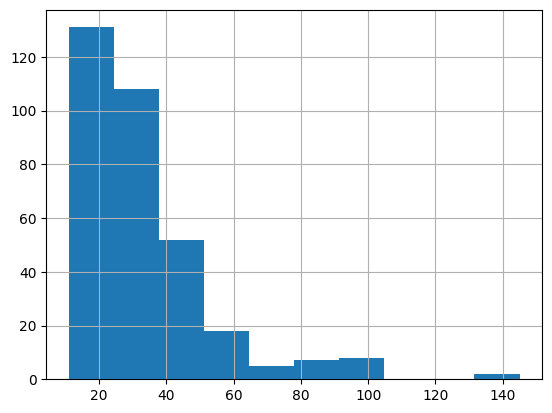

In [25]:
df[df['region_1'] == 'Livermore Valley']['price'].hist();

In [26]:
df[df['region_1'] == 'Livermore Valley']['price'].shape

(331,)

In [27]:
df[df['region_1'] == 'Livermore Valley']['price'].median() # Точная оценка равна 27

27.0

In [28]:
# Создаём бутстрап-сэмплы
def get_bootstrap_samples(data, n_samples): # данные, количество сэмплов
    # берём индексы данных
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    # по индексам ним забираем данные 
    samples = data[indices]
    # возвращаем сэмплы
    return samples

# Строим интервальную оценку статистики, границы задаются пёрцентилями
def stat_intervals(stat, alpha): 
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [29]:
np.random.seed(17)  # Фиксируем random

median_region_prices = list(map(
    np.median,
    get_bootstrap_samples(df[df['region_1'] == 'Livermore Valley']['price'].values,
    10000))) # на 10000 выборках


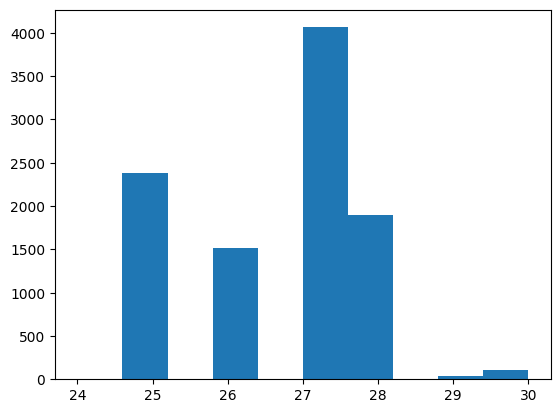

In [30]:
plt.hist(median_region_prices)  # Посмотрим распределение полученной выборки

In [31]:
stat_intervals(median_region_prices,0.05)  # Строим 95% доверительный интервал

array([25., 28.])

С 95% вероятностью медианная стоимость вина от 25 до 28 долларов. Точная оценка была равна 27, как раз входи в данный интервал